In [1]:
import numpy             as np
import scipy             as sp
import matplotlib.pyplot as plt
import time
from numba import njit

from tqdm            import tqdm
from scipy           import signal

from propagation import received_power_nonlambertian, quad_distribute_power, propagation_delay, \
                        map_rx_config, map_tx_config_nonlambertian, \
                        gen_qrx_onlyclocked

from parametermeasurement import generate_clocks, measure_range_roberts, measure_bearing

from positioning import classicalfix_directbearing_mle, classicalfix_diffbearing_mle, \
                        classicalfix_directrange_mle, classicalfix_diffrange_mle

### Simulation preliminaries

In [2]:
weather     = 'fog' 
temperature = 298 # Kelvin
daynight    = 'day_indirectsun'

daynight_noise_factors = dict()
daynight_noise_factors['day_directsun']   = 1.000 # 5100 uA
daynight_noise_factors['day_indirectsun'] = 0.145 # 740 uA
daynight_noise_factors['night']           = 0.010 # very small

# minmax bounds to be safe if you set the noise factor yourself
bg_current = (np.minimum(1, np.maximum(0, daynight_noise_factors[daynight]))*5100)*1e-6;

weather_attenuation_factors = dict()
weather_attenuation_factors['clear'] = 0.0
weather_attenuation_factors['rain']  = -0.05
weather_attenuation_factors['fog']   = -0.2

atten = weather_attenuation_factors[weather];

In [3]:
a = np.load('optics/qrx_planoconvex.npz');
f_QRX, pd_snst, pd_gain, pd_dim, rx_P_rx_factor, rx_I_bg_factor, rx_thermal_factor1, rx_thermal_factor2 = map_rx_config(a);

In [4]:
a = np.load('optics/tx_AgonLbSedan1_2W.npz')
tx_pattern, tx_phiarray, tx_thetaarray, tx_pwr, tx_norm = map_tx_config_nonlambertian(a);

this factor is precomputed since it's the same for all links (/16 due to $C_i^2$ in the thermal_factor2, each cell gets 1/4 of the total cap)

In [5]:
# original bandwidth = 10 MHz, we assume a 100 kHz BPF here like bechadergue, effectively reducing BW by 100x 
#
# see noise variance equations for further info on this
bandwidth_scaling_due_to_filter = 0.01;
thermal_and_bg_curr = rx_I_bg_factor *  bandwidth_scaling_due_to_filter * bg_current + \
                      temperature    *( bandwidth_scaling_due_to_filter * rx_thermal_factor1 + \
                                      ( bandwidth_scaling_due_to_filter**3) * rx_thermal_factor2/16)

add_noise = 1

### Simulate propagation

In [6]:
a = np.load('trajectories/generated_platooning.npz')

trajectory_partial_numsamples = 1000 # 1000 is the whole thing actually...

L = 1.6 # [m]

xRL_to_rxL = a['x_RL'][0:trajectory_partial_numsamples]; yRL_to_rxL = a['y_RL'][0:trajectory_partial_numsamples]; 
xRR_to_rxL = a['x_RR'][0:trajectory_partial_numsamples]; yRR_to_rxL = a['y_RR'][0:trajectory_partial_numsamples]
yRL_to_rxR = a['y_RL'][0:trajectory_partial_numsamples]; yRR_to_rxR = a['y_RR'][0:trajectory_partial_numsamples]; 
hdg  = a['hdg'][0:trajectory_partial_numsamples];
xRL_to_rxR = a['x_RL'][0:trajectory_partial_numsamples] - L;
xRR_to_rxR = a['x_RR'][0:trajectory_partial_numsamples] - L;

#t2 = np.linspace(0,1,1000)
#t1 = np.linspace(0,1,4000)
#trajectory_partial_numsamples = 4000
#xRL_to_rxL = np.interp(t1, t2, xRL_to_rxL)
#yRL_to_rxL = np.interp(t1, t2, yRL_to_rxL)
#xRL_to_rxR = np.interp(t1, t2, xRL_to_rxR)
#yRL_to_rxR = np.interp(t1, t2, yRL_to_rxR)
#xRR_to_rxL = np.interp(t1, t2, xRR_to_rxL)
#yRR_to_rxL = np.interp(t1, t2, yRR_to_rxL)
#xRR_to_rxR = np.interp(t1, t2, xRR_to_rxR)
#yRR_to_rxR = np.interp(t1, t2, yRR_to_rxR)
#hdg = np.interp(t1, t2, hdg)

f_vehicle = 1e3;         # [Hz], trajectory simulation clock rate, fixed by trajectory generation
t_vehicle = 1/f_vehicle; # [s] , trajectory simulation clock period, fixed by trajectory generation

In [7]:
localization_decimation_rate = 10
localization_rate = 1/(t_vehicle*localization_decimation_rate)
localization_num_steps = int(trajectory_partial_numsamples/localization_decimation_rate)
print("localization rate:", localization_rate, "Hz")
print("so each localization period considers", localization_decimation_rate, "trajectory samples")
print("and there are a total of", localization_num_steps, "steps")

localization rate: 100.0 Hz
so each localization period considers 10 trajectory samples
and there are a total of 100 steps


In [8]:
c         = 299702547 #299702547  # [m/s] speed of light
f_e       = 1.0e6;    # [Hz], emitted wave freq, left TX

f_adc_clock  = 1e7;             # [Hz], measurement clock freq
t_adc_clock  = 1/f_adc_clock;   # [s] , measurement clock period

simulation_start  = t_adc_clock; # [s]
simulation_stop   = trajectory_partial_numsamples*t_vehicle;
simulation_length = int(simulation_stop/t_adc_clock)
print("Simulation stop time:",simulation_stop)
print("Simulation length   :",simulation_length)

s_simulation   = np.linspace(simulation_start, simulation_stop, simulation_length)

vehicle_time_start  = t_vehicle;
vehicle_time_stop   = simulation_stop;
vehicle_time_length = int(vehicle_time_stop/t_vehicle)

s_vehicle_time = np.linspace(vehicle_time_start, vehicle_time_stop, vehicle_time_length)

Simulation stop time: 1.0
Simulation length   : 10000000


In [9]:
pwr_txL_to_rxL = np.zeros(xRL_to_rxL.shape)
pwr_txL_to_rxR = np.zeros(xRL_to_rxL.shape)
pwr_txR_to_rxL = np.zeros(xRL_to_rxL.shape)
pwr_txR_to_rxR = np.zeros(xRL_to_rxL.shape)

for i in tqdm(range(0,xRL_to_rxL.shape[0])):
    pwr_txL_to_rxL[i] = received_power_nonlambertian(xRL_to_rxL[i], yRL_to_rxL[i], 0, pd_dim/1000, hdg[i], 
                                                  tx_pwr, tx_norm, tx_pattern, tx_thetaarray, tx_phiarray, atten)
    pwr_txL_to_rxR[i] = received_power_nonlambertian(xRL_to_rxR[i], yRL_to_rxR[i], 0, pd_dim/1000, hdg[i], 
                                                  tx_pwr, tx_norm, tx_pattern, tx_thetaarray, tx_phiarray, atten)
    pwr_txR_to_rxL[i] = received_power_nonlambertian(xRR_to_rxL[i], yRR_to_rxL[i], 0, pd_dim/1000, hdg[i], 
                                                  tx_pwr, tx_norm, tx_pattern, tx_thetaarray, tx_phiarray, atten)
    pwr_txR_to_rxR[i] = received_power_nonlambertian(xRR_to_rxR[i], yRR_to_rxR[i], 0, pd_dim/1000, hdg[i], 
                                                  tx_pwr, tx_norm, tx_pattern, tx_thetaarray, tx_phiarray, atten)

shared_pwr_txL_to_rxL = quad_distribute_power(xRL_to_rxL, yRL_to_rxL, 0, f_QRX, pwr_txL_to_rxL)
shared_pwr_txL_to_rxR = quad_distribute_power(xRL_to_rxR, yRL_to_rxR, 0, f_QRX, pwr_txL_to_rxR)
shared_pwr_txR_to_rxL = quad_distribute_power(xRR_to_rxL, yRR_to_rxL, 0, f_QRX, pwr_txR_to_rxL)
shared_pwr_txR_to_rxR = quad_distribute_power(xRR_to_rxR, yRR_to_rxR, 0, f_QRX, pwr_txR_to_rxR)

delay_txL_to_rxL = propagation_delay(xRL_to_rxL, yRL_to_rxL, c)
delay_txL_to_rxR = propagation_delay(xRL_to_rxR, yRL_to_rxR, c)
delay_txR_to_rxL = propagation_delay(xRR_to_rxL, yRR_to_rxL, c)
delay_txR_to_rxR = propagation_delay(xRR_to_rxR, yRR_to_rxR, c)

  0%|                   | 0/1000 [00:00<?, ?it/s]/home/ubuntu/vehicular-vlp-simulations/propagation.py:197: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "propagation.py", line 161:
@njit(parallel=True, fastmath=True)
def getinterp(y2,y1,x2,x1,xnew):
^

  eps1xy1zy_z_interp_right = getinterp(eps1xy1zy_z_top_top, eps1xy1zy_z_top_bot,
100%|███████| 1000/1000 [00:05<00:00, 174.30it/s]


### Simulate methods

In [10]:
add_noise = 1;

In [11]:
iterations = 100;

aoa_rxL_txL = np.zeros((iterations, localization_num_steps)); 
aoa_rxR_txL = np.zeros((iterations, localization_num_steps));
d_rxL_txL   = np.zeros((iterations, localization_num_steps)); 
d_rxR_txL   = np.zeros((iterations, localization_num_steps));

est_x_directbearing = np.zeros((iterations, localization_num_steps)); 
est_y_directbearing = np.zeros((iterations, localization_num_steps));
est_x_directrange   = np.zeros((iterations, localization_num_steps)); 
est_y_directrange   = np.zeros((iterations, localization_num_steps));

for j in tqdm(range(0,iterations)):
    for i in range(0, localization_num_steps):
        smp_lo = i*localization_decimation_rate
        smp_hi = (i+1)*localization_decimation_rate

        step_time       = s_vehicle_time[smp_lo:smp_hi]
        simulation_time = s_simulation[int(i*f_adc_clock/f_vehicle):int((i+1)*f_adc_clock/f_vehicle)]

        rxLL, rxLR, rxRL, rxRR, delays = gen_qrx_onlyclocked(shared_pwr_txL_to_rxL, shared_pwr_txL_to_rxR, shared_pwr_txR_to_rxL, shared_pwr_txR_to_rxR,
                                                             delay_txL_to_rxL, delay_txL_to_rxR, delay_txR_to_rxL, delay_txR_to_rxR,
                                                             f_e, f_e, pd_snst, pd_gain, thermal_and_bg_curr, rx_P_rx_factor,
                                                             step_time, simulation_time, smp_lo, smp_hi, add_noise);
        (rxLA_txL, rxLB_txL, rxLC_txL, rxLD_txL) = rxLL
        (rxLA_txR, rxLB_txR, rxLC_txR, rxLD_txR) = rxLR
        (rxRA_txL, rxRB_txL, rxRC_txL, rxRD_txL) = rxRL
        (rxRA_txR, rxRB_txR, rxRC_txR, rxRD_txR) = rxRR 
        (delayLL_sigTime, delayLR_sigTime, delayRL_sigTime, delayRR_sigTime) = delays

        del rxLL, rxLR, rxRL, rxRR, delays 

        # initial transmitted signal is known (mark the +, that's because the signal does a roundtrip
        # which is 1 delay earlier than echo transmission from target vehicle)
        ### pi/32 to show it works with initial phase offset too
        wav_rxL_txL = np.sin(2*np.pi*f_e*(simulation_time + delayLL_sigTime))
        wav_rxR_txL = np.sin(2*np.pi*f_e*(simulation_time + delayLR_sigTime))

        d_rxL_txL[j,i] = measure_range_roberts(rxLA_txL+rxLB_txL+rxLC_txL+rxLD_txL, wav_rxL_txL, c, f_e)
        d_rxR_txL[j,i] = measure_range_roberts(rxRA_txL+rxRB_txL+rxRC_txL+rxRD_txL, wav_rxR_txL, c, f_e)

        # assume that the VLC subsystem correctly decodes the signal (mark that the delayed signal 
        # is decoded, so the delay isn't actually measured, it's implicitly present on the RX signal)
        ### pi/32 to show it works with initial phase offset too
        wav_rxL_txL = np.sin(2*np.pi*f_e*(simulation_time - delayLL_sigTime))
        wav_rxR_txL = np.sin(2*np.pi*f_e*(simulation_time - delayLR_sigTime))

        thd = 1e-5; # just to avoid messing up the graphs when aoa detection is too bad.
        aoa_rxL_txL[j,i] = measure_bearing(rxLA_txL, rxLB_txL, rxLC_txL, rxLD_txL, wav_rxL_txL, f_QRX, thd)
        aoa_rxR_txL[j,i] = measure_bearing(rxRA_txL, rxRB_txL, rxRC_txL, rxRD_txL, wav_rxR_txL, f_QRX, thd)

        est_x_directbearing[j,i], est_y_directbearing[j,i] = classicalfix_directbearing_mle(aoa_rxL_txL[j,i], aoa_rxR_txL[j,i], L)
        est_x_directrange[j,i], est_y_directrange[j,i]     = classicalfix_directrange_mle(d_rxL_txL[j,i], d_rxR_txL[j,i], L)

  0%|                    | 0/100 [00:00<?, ?it/s]/home/ubuntu/vehicular-vlp-simulations/positioning.py:102: RuntimeWarning: invalid value encountered in scalar divide
  est_x = L*(1 + np.sin(np.deg2rad(aoaR))*np.cos(np.deg2rad(aoaL))/np.sin(np.deg2rad(aoaL - aoaR)));
/home/ubuntu/vehicular-vlp-simulations/positioning.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  est_y = L*np.cos(np.deg2rad(aoaR))*np.cos(np.deg2rad(aoaL))/np.sin(np.deg2rad(aoaL - aoaR));
/home/ubuntu/vehicular-vlp-simulations/positioning.py:108: RuntimeWarning: invalid value encountered in sqrt
  est_y = np.sqrt(dL**2-est_x**2)
100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


np.savez('es4_'+weather+daynight+'_nonlambertian.npz', 
        xRL_to_rxL=xRL_to_rxL, yRL_to_rxL=yRL_to_rxL, xRL_to_rxR=xRL_to_rxR, yRL_to_rxR=yRL_to_rxR,
        hdg=hdg, c=c, f_e = f_e,
        d_rxL_txL=d_rxL_txL, d_rxR_txL=d_rxR_txL, aoa_rxL_txL=aoa_rxL_txL, aoa_rxR_txL=aoa_rxR_txL,
        est_x_directbearing=est_x_directbearing, est_y_directbearing=est_y_directbearing,
        est_x_directrange=est_x_directrange, est_y_directrange=est_y_directrange,
        f_adc_clk=f_adc_clock,
        daynight=daynight,
        weather=weather,
        temperature=temperature)

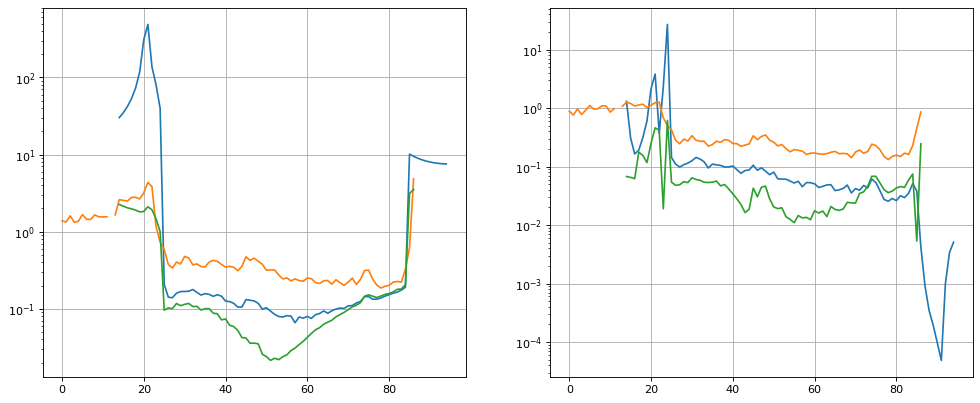

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15, 6), dpi=80)
error_x_db = np.zeros((iterations, localization_decimation_rate, localization_num_steps))
error_y_db = np.zeros((iterations, localization_decimation_rate, localization_num_steps))
error_x_dr = np.zeros((iterations, localization_decimation_rate, localization_num_steps))
error_y_dr = np.zeros((iterations, localization_decimation_rate, localization_num_steps))

for i in range(0, localization_num_steps):
    for j in range(0, localization_decimation_rate):
        for k in range(0, iterations):
            error_x_db[k,j,i] = est_x_directbearing[k,i] - xRL_to_rxL[i*localization_decimation_rate + j]
            error_y_db[k,j,i] = est_y_directbearing[k,i] - yRL_to_rxL[i*localization_decimation_rate + j]
            error_x_dr[k,j,i] = est_x_directrange[k,i] - xRL_to_rxL[i*localization_decimation_rate + j]
            error_y_dr[k,j,i] = est_y_directrange[k,i] - yRL_to_rxL[i*localization_decimation_rate + j]

error_xy_db = np.sqrt(error_x_db**2 + error_y_db**2)
error_xy_dr = np.sqrt(error_x_dr**2 + error_y_dr**2)
error_xy_cm = np.sqrt(error_x_db**2 + error_y_dr**2)
ax[0].semilogy(np.amax(np.mean(error_xy_db,axis=0), axis=0))
ax[0].semilogy(np.amax(np.mean(error_xy_dr,axis=0), axis=0))
ax[0].semilogy(np.amax(np.mean(error_xy_cm,axis=0), axis=0))
ax[0].grid()
ax[1].semilogy(np.amax(np.std(error_xy_db,axis=0), axis=0))
ax[1].semilogy(np.amax(np.std(error_xy_dr,axis=0), axis=0))
ax[1].semilogy(np.amax(np.std(error_xy_cm,axis=0), axis=0))
ax[1].grid()